#### <b>GAN 실습</b>

*   https://arxiv.org/pdf/1406.2661.pdf



#### <b>필요한 라이브러리 불러오기</b>

* 실습을 위한 PyTorch 라이브러리를 불러옵니다.

In [1]:
import torch
import torch.nn as  # 생성자, 판별자의 architecture 구현하기 위해서

from torchvision import datasets # MNIST 데이터셋
import torchvision.transforms as transforms # 의도한 방향으로 변형하기위해 전처리하기 위해서
from torchvision.utils import save_image # 학습이 진행되는 동안 반복된 이미지를 저장

#### <b>생성자(Generator) 및 판별자(Discriminator) 모델 정의</b>

In [2]:
latent_dim = 100 # noise 분포의 dimension


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            # LeakyReLu : leaky relu는 임계치보다 작으면 0.01을 곱해야 하기 때문에 연산 비용이 상대적으로 큽니다. -> 연산 비용이 크다는 것은 속도가 그만큼 느리다는 것
            # https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28), #(1,28,28) MNIST 데이터를 만든다.
            nn.Tanh() # -1~1사이의 값으로 만든다.
        )

    def forward(self, z): # random vector 'z'값
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [ ]:
'''
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(100,)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(28*28*1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

Latant Vector z를 입력으로 받아, Dense Layer(완전 연결 신경망)을 겹겹히 쌓아 출력의 전체 개수인 784개의 뉴런까지 확장하는 모습입니다.
Relu 활성화 함수를 사용하고, 마지막 Layer에서 Tanh 활성화 함수를 사용하여 뉴런의 값을 -1~1사이로 확정
'''

In [3]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(), # 확률값을 내보낸다.
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1) # 한장의 이미지가 들어왔을때
        output = self.model(flattened)

        return output

In [ ]:
'''
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))

    return model
입력으로 받은 28x28 크기의 데이터를 1차원 Vector 형태로 변환한 후, Dense Layer를 이용하여 점차적으로 축소시킵니다.
마지막 Layer까지 Relu 활성화함수를 거쳐왔기 때문에, 0 보다 작은 데이터는 0에 매우 근사하게 위치할 것이고, Input을 -1~1사이의 이미지로 정의했기 때문에 최종값 또한 근사치로 나올 것을 예상
'''

#### <b>학습 데이터셋 불러오기</b>

* 학습을 위해 MNIST 데이터셋을 불러옵니다.

In [4]:
transforms_train = transforms.Compose([ # 원하는 형태로 전처리하기 위해서
    transforms.Resize(28),
    transforms.ToTensor(), #pytorch의 tensor형태로 ~
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#### <b>모델 학습 및 샘플링</b>

* 학습을 위해 생성자와 판별자 모델을 초기화합니다.
* 적절한 하이퍼 파라미터를 설정합니다.

In [5]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda() # cuda function을 통해서 GPU로 작동하게 한다.
discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

Generator와 Discriminator 모두 loss를 계산 할 때, Discriminator의 출력 값을 기준으로 합니다. 

-> Discriminator의 출력이 0 또는 1으로 수렴해야하기에, BinaryCrossentropy 사용

In [ ]:
'''
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
'''

Generator의 목적은 Generator가 생성한 이미지를 Discriminator가 1(진짜이미지)으로 판별하도록하는 것입니다. 따라서 Generator의 Loss는 생성한 이미지를 Discriminator가 판별한 결과를 입력으로 받아서, 그 값이 얼마나 1에서 멀리있는가 를 기준으로 Loss를 결정

In [ ]:
'''
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
'''

Discriminator의 목적은 Generator가 생성한 이미지는 0(가짜)으로 판별하고, 진짜 이미지는 1(진짜)으로 판별!

Discriminator의 Loss는 두 개의 Loss를 합쳐서 결정

* 모델을 학습하면서 주기적으로 샘플링하여 결과를 확인할 수 있습니다.

In [6]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 -> 손실함수를 G,D 두 개꺼를 사용한다.
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Epoch 0/200] [D loss: 0.370634] [G loss: 1.313595] [Elapsed time: 11.69s]
[Epoch 1/200] [D loss: 0.350168] [G loss: 1.547963] [Elapsed time: 23.50s]
[Epoch 2/200] [D loss: 0.386932] [G loss: 2.622983] [Elapsed time: 35.45s]
[Epoch 3/200] [D loss: 0.477071] [G loss: 2.867832] [Elapsed time: 47.53s]
[Epoch 4/200] [D loss: 0.355211] [G loss: 0.895684] [Elapsed time: 59.35s]
[Epoch 5/200] [D loss: 0.265109] [G loss: 2.316051] [Elapsed time: 71.20s]
[Epoch 6/200] [D loss: 0.255561] [G loss: 1.839427] [Elapsed time: 83.39s]
[Epoch 7/200] [D loss: 0.262028] [G loss: 1.461574] [Elapsed time: 95.73s]
[Epoch 8/200] [D loss: 0.397916] [G loss: 5.082265] [Elapsed time: 107.88s]
[Epoch 9/200] [D loss: 0.256739] [G loss: 2.022913] [Elapsed time: 120.12s]
[Epoch 10/200] [D loss: 1.277637] [G loss: 6.359732] [Elapsed time: 132.17s]
[Epoch 11/200] [D loss: 0.379443] [G loss: 1.316124] [Elapsed time: 144.30s]
[Epoch 12/200] [D loss: 0.159441] [G loss: 3.264759] [Elapsed time: 156.53s]
[Epoch 13/200] [D

* 생성된 이미지 예시를 출력합니다.

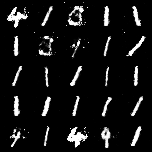

In [7]:
from IPython.display import Image

Image('92000.png')